# Exercise 3 – Hyperspectral Image Analysis (nmbu.npy)

We will work with the hyperspectral airborne image **`nmbu.npy`** (TF-buildings & Aud Max), with header file **`nmbu.hdr`**.  
An RGB representation is shown in Figure 5.  

---

### Part (a) – Load & Display (5p)
- Load `nmbu.npy` and `nmbu.hdr`.  
- Display RGB by selecting **3 wavebands**.  
- Report which bands were chosen and their wavelengths.  

---

### Part (b) – Spectral Plot (5p)
- Plot spectrum vs. wavelength for the following materials:  
  - Grass  
  - Asphalt  
  - Black roof  
  - Red roof  
  - Solar panels  
  - Water  

---

### Part (c) – NDVI (5p)
- Compute **NDVI (Normalized Difference Vegetation Index)**.  
- Display the NDVI image.  

---

### Part (d) – PCA (15p)
- Perform **Principal Component Analysis (PCA)**.  
- Display the **5 first score images** with corresponding loadings.  
- Interpret what can be observed from these figures.  
- Plot **Eigenvalues** and explain the break at component no. 2.  
- Report explained variance in first 2 components.  
- Determine how many components cover **99.9% variance**.  

---

### Part (e) – Gaussian Maximum Likelihood Classification (10p)
- Perform **classification (4–6 classes)** using:  
  1. Full hyperspectral image  
  2. Stack of first 8 PCA score images  
- Show **ground truth** with classes.  
- Display classification results for both approaches.  
- Compare and comment on results.  

---

### Part (f) – Vegetation Edge Detection (10p)
- Apply an **edge detection filter** on the vegetation class.  
- Overlay with the NDVI image to highlight vegetation areas (as in Figure 6).  

---


## Table of contents
- <a href='#E3a'>Exercise 3 </a>
    - <a href='#E3a'>Exercise 3 (a): Loading the image, selecting the wavelengths & the waveband numbers </a>
    - <a href='#E3b'>Exercise 3 (b): Generating Spectrum image with the given materials </a>
    - <a href='#E3c'>Exercise 3 (c): NDVI calculation & NDVI Image display </a>
    - <a href='#E3d'>Exercise 3 (d): Principal Component Analysis of the data</a>
    - <a href='#E3e'>Exercise 3 (e): Gaussian Maximum Likelihood Classification</a>
    - <a href='#E3f'>Exercise 3 (f): Outlining the vegetation using edge detecting filters</a>


--------------------------------------------------------------------------------------------
## Solution starts here
--------------------------------------------------------------------------------------------

<a id='E3a'></a>
# <font color='blue '>Exercise 3 (a): Loading the image, selecting the wavelengths & the waveband numbers <font>


### Choosing  the wavelengths & the waveband numbers   
    
At first, I loaded the image and the header file by python. Since no wavelengths for the RGB was given in the question. For getting the required waveband numbers from the header file, I have to chose the wavelengths for each of the RGB color and the infrared (NIR) color.

We know the wavelength range for the RGB colors are: (Source: https://www.en.silicann.com/blog/post/wavelength-color/)
- Entire Red spectrum approx. 650–750 nm
- Entire Green spectrum approx. 490–575 nm
- Entire Blue spectrum approx. 420–490 nm

I have approximately taken the middle value from each the spectrum and calculated the wave band numbers using those.
- For Red: chosen 650nm
- For Green: chosen 540nm
- For Blue: chosen 450nm

The infrared radiation (NIR) starts at wavelengths greater than 780nm. So, chosen 800nm for NIR.

The function find_wavebands() takes a list of all the 186 wavelengths and a dictionary of required wavelengths which has waveband name as keys and wavelength as values. It finds the band numbers nearest to the given wavelengths. Then returns a dictionary which has color names as keys and their waveband number as values.

Using my chosen wavelengths, I got the following wavebands:
- Red: waveband 77
- Green: waveband 42
- Blue: waveband 14   
- NIR: waveband 124   

In [ ]:
# Importing all the necessary modules
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
import skimage

# For edge detection filters
from skimage import filters #sobel,  prewitt & laplace
from skimage import feature# canny

# For using morphology
from skimage.morphology import dilation, square

In [ ]:
def find_wavebands(all_wavelengths, required_wavelengths):
    """ Parameters:
            all_wavelengths: list of all 186 wavelengths available
            required_wavelengths:  a dictionary which has band names as keys and wavelength as values.
        Return:
            required_bands: a dictionary which has band names as keys and band number as values """

    required_bands = {}
    for given_wavelength in required_wavelengths.keys():
        band_name = required_wavelengths[given_wavelength]
        wave_band = min(enumerate(all_wavelengths), key=lambda curr_wavelength: abs(curr_wavelength[1]-given_wavelength))
        required_bands[band_name] = wave_band[0]
    return required_bands

In [ ]:
# Loading the image
hyperim = np.load("nmbu.npy")

# Loading the header file for getting wavelengths
wavelength = envi.read_envi_header('nmbu.hdr')['wavelength'] # String format
all_wavelengths = [float(i) for i in wavelength] # Converting to float format

# Wavelengths chosen by me
required_wavelengths = {450:"blue", 540:'green', 650:'red', 800:'NIR'}

# Calling the function to get required wavebands
required_bands = find_wavebands(all_wavelengths, required_wavelengths)
print("Wavelength available:", len(wavelength))
print("Wavebands:", required_bands)

Wavelength available: 186
Wavebands: {'blue': 14, 'green': 42, 'red': 77, 'NIR': 124}


In [ ]:
# Organising the RGB wavebands in list format
RGB_bands = [required_bands['red'],required_bands['green'],required_bands['blue']]
print("RGB wavebands in list format:", RGB_bands)
NIR_band = required_bands['NIR']
print("NIR waveband", NIR_band)
red_band = required_bands['red']
print("Red band", red_band)

RGB wavebands in list format: [77, 42, 14]
NIR waveband 124
Red band 77


### Diplaying RGB image with only 1 band for each color

With the chosen wavelengths & detected waveband numbers for red, green and blue, an RGB image was computed by adding those band numbers according to their respective color channels.

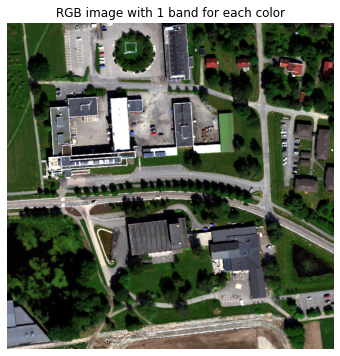

In [ ]:
#Displaying the RGB image
imshow(hyperim, bands = RGB_bands, stretch=((0.02,0.98),(0.02,0.98),(0.02,0.98)), figsize=(10,6))
plt.title("RGB image with 1 band for each color")
plt.axis('off')
plt.show()

<center>Figure- 14: RGB image with 1 band for each color</center>

### Displaying RGB image with an average of 10 bands for each color
Since each color might belong to a range of bands, an average of the nearest 10 bands have been taken for each color channel. Then, a new RGB image has been created.

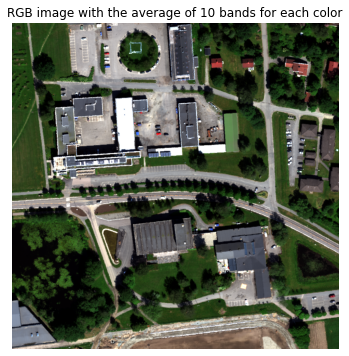

In [ ]:
# Creating a copy of the original image
RGB_average_hyperim = hyperim[:, :, :]

# Creating a average of 10 bands for each color
blue_avg = RGB_average_hyperim [:, :, required_bands['blue']-5:required_bands['blue']+5 +1 ].mean(axis=2)
green_avg = RGB_average_hyperim [:, :, required_bands['green']-5:required_bands['green']+5 +1 ].mean(axis=2)
red_avg = RGB_average_hyperim [:, :, required_bands['red']-5:required_bands['red']+5 +1 ].mean(axis=2)

shape = RGB_average_hyperim.shape
RGB_avg = np.zeros([shape[0], shape[1], 3])
RGB_avg[:, :, 0] = red_avg
RGB_avg[:, :, 1] = green_avg
RGB_avg[:, :, 2] = blue_avg

# Displaying the RGB image
imshow(RGB_avg, stretch=((0.02,0.98),(0.02,0.98),(0.02,0.98)), figsize=(10,6))
plt.title("RGB image with the average of 10 bands for each color")
plt.axis('off')
plt.show()

<center>Figure- 15: RGB image with the average of 10 bands for each color</center>

### Comment on the RGB image with 1 band and the RGB image with the average of 10 bands.
Each of the color belongs to multiple bands, so instead of taking just 1 band, if we take a range of bands(10 bands) belonging to that color, the image quality is slightly improved.

<a id='E3b'></a>
# <font color='blue '>Exercise 3 (b): Generating Spectrum image with the given materials <font>


### Spectra image with the selected pixel points:

Six pixel points corresponding to the following materials have been selected from the image and their values have been plotted in the spectra image.
- Grass
- Asphalt
- Black roof
- Red roof
- Solar panels
- Water

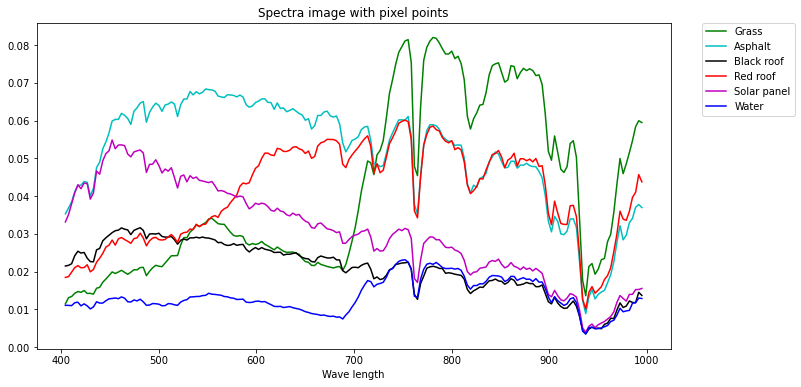

In [ ]:
#spectrum of 1 pixel for each material/region
grass = np.array(hyperim[402, 40, :].reshape(-1,1)) # Grass
asphalt = np.array(hyperim[253, 769, :].reshape(-1,1))# Asphalt
black_roof = np.array(hyperim[719, 735, :].reshape(-1,1)) # Black roof
red_roof = np.array(hyperim[133, 886, :].reshape(-1,1)) # Red roof
solar_panel = np.array(hyperim[405, 429, :].reshape(-1,1)) # Solar panel
water = np.array(hyperim[713, 896, :].reshape(-1,1)) # Water

#Diplaying the spectra
fig, ax_dict = plt.subplot_mosaic([ ['bottom', 'BLANK']], empty_sentinel="BLANK", figsize = (25, 6))

ax_dict['bottom'].plot(all_wavelengths,  grass, color = 'g', label='Grass')
ax_dict['bottom'].plot(all_wavelengths, asphalt, color = 'c', label='Asphalt')
ax_dict['bottom'].plot(all_wavelengths, black_roof, color = 'k',label='Black roof')
ax_dict['bottom'].plot(all_wavelengths,  red_roof, color = 'r', label='Red roof')
ax_dict['bottom'].plot(all_wavelengths, solar_panel, color = 'm', label='Solar panel')
ax_dict['bottom'].plot(all_wavelengths, water , color = 'b',label='Water')

ax_dict['bottom'].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Spectra image with pixel points")
plt.xlabel("Wave length")
plt.show()

<center>Figure- 16: Spectra image with pixel points</center>

### Comment on the Spectra image
- We know the Red color has the wave length from 620 to 720nm, and NIR has wavelength from 800 to 2,500nm. Usually in the spectra image, anything that has a higher presense in the wavelength starting after Red (720nm) and before NIR (800nm) are considered vegetation.

- From the Figure-16, spectrum image, we can see that
  - Grass (vegatation) has a spike from approximately 680nm which continued till approximately 930nm, proving the presense of chlorophyll in that range of wavelength (vegetation spectrum). Small peak in the Green spectrum zone (490 to 575 nm), justifies the vegetation reflecting green lights.
  - The water is supposed to be blue. But due to the presense of vegetation (water hyacinth/plants) in the water, it has the curve similar to the vegetation curve. With a negligible peak at the green spectrum zone.
  - The dark roof has a very flat spectrum curve, without any spikes in the vegetation considered wavelength zone.
  - The red-roof reflected red color which justifies the high peak value in the red spectrum zone (approx. 650–750 nm)
  - The asphalt does not have any specific distinctive characteristics here.
  - From 700 to 950nm wavelengths, all the spectrums have a similar shape which varies in height due to the intensity variation.
  


### Mean spectrum of 20x20 pixels for each material/region
Ineasted of choosing only 1 pixel for each of the material, 20x20 pixel area had been selected from the image and their values have been plotted in the spectra image.

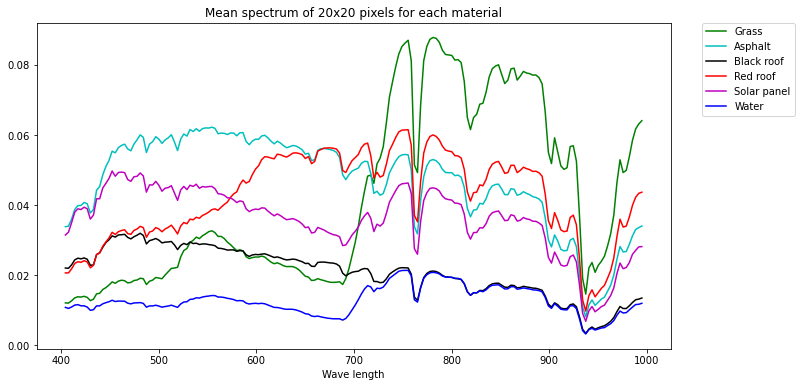

In [ ]:
# Mean spectrum of 20x20 pixels for each material/region

grass1 = hyperim[402:422, 40:60, :].mean(axis = 0) # Grass
grass = grass1.mean(axis=0).reshape(-1,1) # Grass

asphalt1 = hyperim[250:270, 770:790, :].mean(axis = 0) # Asphalt
asphalt = asphalt1.mean(axis=0).reshape(-1,1) # Asphalt

black_roof1 = hyperim[720:740, 735:755, :].mean(axis = 0) # Black roof
black_roof = black_roof1.mean(axis=0).reshape(-1,1)  # Black roof

red_roof1 = hyperim[133:153, 886:906, :].mean(axis = 0) # Red roof
red_roof = red_roof1.mean(axis=0).reshape(-1,1) # Red roof

solar_panel1 = hyperim[405:415, 428:438, :].mean(axis = 0) # Solar panel
solar_panel = solar_panel1.mean(axis=0).reshape(-1,1) # Solar panel

water1 = hyperim[715:735, 900:920, :].mean(axis = 0) # Water
water = water1.mean(axis=0).reshape(-1,1) # Water

# Displaying the image
fig, ax_dict = plt.subplot_mosaic([ ['bottom', 'BLANK']], empty_sentinel="BLANK", figsize = (25, 6))

ax_dict['bottom'].plot(all_wavelengths,  grass, color = 'g', label='Grass')
ax_dict['bottom'].plot(all_wavelengths, asphalt, color = 'c', label='Asphalt')
ax_dict['bottom'].plot(all_wavelengths, black_roof, color = 'k',label='Black roof')
ax_dict['bottom'].plot(all_wavelengths,  red_roof, color = 'r', label='Red roof')
ax_dict['bottom'].plot(all_wavelengths, solar_panel, color = 'm', label='Solar panel')
ax_dict['bottom'].plot(all_wavelengths, water , color = 'b',label='Water')

ax_dict['bottom'].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Mean spectrum of 20x20 pixels for each material")
plt.xlabel("Wave length")
plt.show()

<center>Figure- 17: Mean spectrum of 20x20 pixels for each material</center>

#### Comment on the Spectra image with points vs  Mean spectrum of 20x20 pixels for each region
From the Figure-16 & Figure-17, we can see that the *Spectra image with points* and *Spectra image with 20x20 pixels* do not have any visible drastic changes, rather they look the same. It implies the range of pixels belonged to almost similar colors/materials. But when I have taken an area instead of only a pixel point, the curves have became slightly smoother.

<a id='E3c'></a>
# <font color='blue '>Exercise 3 (c): NDVI calculation & NDVI Image display <font>

##### NDVI index can be calculated in 2 ways:
- Method1: Manually using the red waveband and NIR waveband
- Method2: Using the built-in python function

#### NDVI calculating using the equation/formula

In [ ]:
# NDVI calculating using the equation/formula
np.seterr(invalid='ignore') #ignoring the Nan values
ndvi_image_manual = (hyperim[:,:,NIR_band]-hyperim[:,:,red_band])/(hyperim[:,:,NIR_band]+hyperim[:,:,red_band])

#### NDVI calculating using the python function

In [ ]:
# NDVI calculating using the python function
np.seterr(invalid='ignore') #ignoring the Nan values
ndvi_image_python = ndvi(hyperim[:,:],red_band, NIR_band)

#### Displaying the NDVI images

In [ ]:
# Plotting the NVDI images
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
fig.suptitle("NDVI images", fontsize = 14)

# NDVI image calculated using equation
img1 = ax[0].imshow(ndvi_image_manual, vmin = -0.2, vmax = 0.92)
ax[0].set_title("NDVI image calculated using equation", fontsize = 13)
plt.colorbar(img1, ax=ax[0])

# NDVI image calculated using python
img2 = ax[1].imshow(ndvi_image_python, vmin = -0.2, vmax = 0.92)
ax[1].set_title("NDVI image calculated using python", fontsize = 13)
plt.colorbar(img2, ax=ax[1])

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

<center>Figure- 18: NDVI images</center>


##### We know the following facts about the NDVI valus:
- High values (0.66 to 1) represent very healthy plants
- Moderate values (0.33 to 0.66) represent moderately healthy plants
- Very low values of NDVI (0.1 and below) correspond to barren areas of rock, sand, or snow. Negative values are often water.
- Source link: https://earthobservatory.nasa.gov/features/MeasuringVegetation

#### Comment on the NDVI images
From the Figure-18, we can see that the NDVI image calculated from both of the methods looks same. Depedning on their NVDI values, they have different colors in the image. Yellow is the highest with NDVI 1 (most healthy). The Objects and the almost dead plants have NDVI value below 0.3 which is represented by the darker colors.

<a id='E3d'></a>
# <font color='blue '>Exercise 3 (d): Principal Component Analysis of the data<font>


At first, the PCA image has been created using 31 principal components (PCs) which explains 99.9% variance present in the image.
    
**Assuming, PC = Principal  Component**

### PCA calcualtion using 31 PCs (99.9% variance explained)

In [ ]:
# PCA image creation with 31 PCs (99.9% variance explained)
pc = principal_components(hyperim)
pc_0999 = pc.reduce(fraction=0.999) # Select the PCs with 99.9% variance explained
img_31PCs = pc_0999.transform(hyperim)  # Then transforming to an image
print("Number of PC's selected:", img_31PCs.shape[2])

# Displaying the 31 PCs stacked image
imshow(img_31PCs, stretch=((0.03, 0.98),(0.03, 0.98),(0.03, 0.98)), figsize=(10,6), title ='PCA image with 31 PCs')
plt.axis('off')
plt.show()

Number of PC's selected: 31


<center>Figure- 19: PCA image with 31 PCs</center>

### Analysis of the PCA Score Plots and their corresponding Loading Plots images
Below the first 5 PCA score plots and their loading plots have been presented.

In [ ]:
# Taking loadings from the PCA
loadings = pc_0999.eigenvectors

In [ ]:
# Function for displaying the score image and the loading plot for each PC
def display_score_plot_N_loading_plot(pc_no, loadings, image, vmin, vmax):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5)) #(width,height)

    ax[0].imshow(img_31PCs[:,:,pc_no], vmin = vmin, vmax = vmax)
    ax[0].set_title('PC' + str(pc_no) + ' score image', fontsize = 13)

    ax[1].plot(all_wavelengths, loadings[:,[pc_no]])
    ax[1].set_title('PC' + str(pc_no) + ' loading plot', fontsize = 13)
    ax[1].set_xlabel('Wavelength', fontsize = 13)
    ax[1].set_ylabel('Intensity', fontsize = 13)

    ax[0].axis('off')

    fig.tight_layout()
    plt.show()

In [ ]:
# For the PC0, generating the score plot and the loading plot
display_score_plot_N_loading_plot(pc_no = 0,  loadings = loadings, image = img_31PCs, vmin = -0.2, vmax = 0.3)

<center>Figure- 20: PC0 score image and its corresponding loading plot</center>

### Comment on PC0:
From the Figure-20, we can understand the followings.
- **Score image**: Differentiates 3 groups:
    - Black roof tops, dark trees, vegetation in pond (represented in dark violet)
    - Grass & few trees (represented in yellow)
    - Rest (represented in green)
- **Loading plot**:
   - PC0 has identified all the vegetations(both grass and trees). A typical vegetation loading plot can be observed which has high values starting after the red spectrum and continued till the NIR. It also has a peak at the green spectrum (490–575 nm) justifiying the reflection of green color by the vegetation.

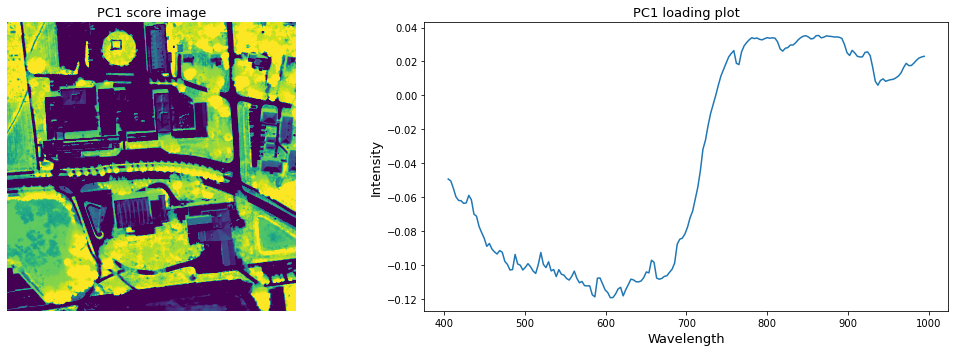

In [ ]:
#For the PC1, generating the score plot and the loading plot
display_score_plot_N_loading_plot(pc_no = 1,  loadings = loadings, image = img_31PCs, vmin=-0.09, vmax = 0.2)

<center>Figure- 21: PC1 score image and its corresponding loading plot</center>

### Comment on PC1:
From the Figure-21, we can understand the followings.
- **Score image**: Differentiates 3 groups:
    - Vegetation (grass, water based vegetation from the pond) (represented in yellowish green)
    - Gable shaped roofs & few small soil fields (represented in teal green/turquoise)
    - Rest (represented in dark violet)
- **Loading plot**:  
  - PC1 has identified all the vegetations(both grass and trees). A typical vegetation loading plot can be observed.

In [ ]:
#For the PC2, generating the score plot and the loading plot
display_score_plot_N_loading_plot(pc_no = 2,  loadings = loadings, image = img_31PCs, vmin=-0.007, vmax = 0.03)

<center>Figure- 22: PC2 score image and its corresponding loading plot</center>

### Comment on PC2:
From the Figure-22, we can understand the followings.
- **Score image**: Differentiates 3 groups:
    - White roof tops (represented in yellow)
    - Concrete made roof tops and grounds, asphalt roads (represented in green)
    - Rest (vegetation & soil grounds) (represented in dark violet)
- **Loading plot**:
  - All the vegetation has been identified in the dark violet/black color. So, a flipped peak at the green spectrum (490 to 575 nm) justifies the reflection of the green by the vegetation.

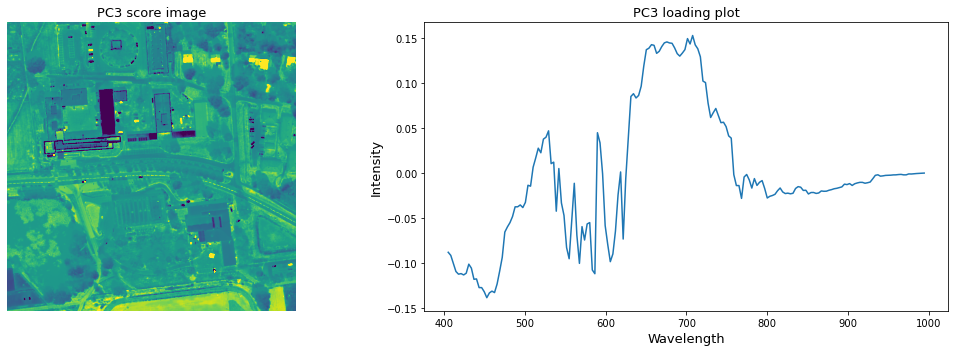

In [ ]:
#For the PC3, generating the score plot and the loading plot
display_score_plot_N_loading_plot(pc_no = 3,  loadings = loadings, image = img_31PCs, vmin=-0.06, vmax = 0.05)

<center>Figure- 23: PC3 score image and its corresponding loading plot</center>

### Comment on PC3:
From the Figure-23, we can understand the followings.
- **Score image**: Differentiates 3 groups:
    - White roof tops (represented in dark violet)
    - Red roof tops (represented in yellow)
    - Rest (represented in green)
- **Loading plot**: Due to the reflectence of red color by the red roof tops, a peak in the red spectrum zone(650–750nm) is noticed.

In [ ]:
#For the PC4, generating the score plot and the loading plot
display_score_plot_N_loading_plot(pc_no = 4,  loadings = loadings, image = img_31PCs, vmin = -0.003, vmax = 0.02)

<center>Figure- 24: PC4 score image and its corresponding loading plot</center>

### Comment on PC4:
From the Figure-24, we can understand the followings.
- **Score image**: Differentiates 3 groups:
    - Green trees, vegetation in the pond, red roof tops (represented in yellow)
    - Dark trees, white roof tops (represented in dark violet)
    - Rest (represented in green)
- **Loading plot**:
  - The identified vegetation in this zone might have high intensity in green color. The green color reflectence in the green sprectrum zone (490–575 nm) in this loading plot is quite high.

## Plotting the eigen values (PCA plot)

In [ ]:
# Generating PCA plot to explain the variance present in the image
plt.figure(figsize=(10,5))
plt.plot(pc.eigenvalues[0:10])
plt.title("PCA plot")
plt.xlabel('Nnumber of Component (PCs)')
plt.ylabel('Explained variance [%]')
plt.xticks(np.arange(0,11,1))
plt.show()

<center>Figure- 25: Plotting the eigen values (PCA plot)</center>

### Comment on the PCA plot:
From the Figure-25, I have identified the following.
- **The break in the curve at component no 2** indicates the amount of components needed to explain the variance presssent in the image. In this case, it is the first 3 PCs.
- From the PCA plot, we can see that, according to the **"Elbow method"**, only the **1st three PCAs** are enough to explain the variance present in the image. But, there is a possibility that the rest of the PCs might have important informations. So, at first we should take more than 3 PCs to check whether they contain any relevant information. From our analysis of the score & loading plots of this image, we can this beyond the 1st three PCs, the PC3 and the PC4 also have important elements present.

### Percentage of the variance explained by the PCs
- **1st 2 PCs (PC0 & PC1) explains 95% variance** present in the image [Shown in the code block below]
- **1st 3 PCs (PC0, PC1 & PC2) explains 97% variance** present in the image [Shown in the code block below]
- **To cover 99.9% variance**, we need the first **31 PCs** present in the image [Shown in the code block below]

In [ ]:
# Percentage of PCs explained by the variance

# Taking 2 PCs
variance_explained = 0.95
pc_2 = pc.reduce(fraction = variance_explained)# select the PCs with 95.00% variance explained
img_2PCs = pc_2 .transform(hyperim) # then transforming to an image
print("Number of PC's selected (PC0 & PC1):", img_2PCs.shape[2])
print("Variance explained by 1st two PCs :", variance_explained*100, "%")
print("===========================================")

# Taking 3 PCs
variance_explained = 0.97
pc_3 = pc.reduce(fraction = variance_explained)# select the PCs with 97.00% variance explained
img_3PCs = pc_3 .transform(hyperim)  # then transforming to an image
print("Number of PC's selected (PC0, PC1 & PC2):", img_3PCs.shape[2])
print("Variance explained by 1st three PCs:", variance_explained*100, "%")
print("===========================================")

# Taking 31 PCs
variance_explained = 0.999
pc_31 = pc.reduce(fraction = variance_explained)# select the PCs with 99.9% variance explained
img_31PCs = pc_31 .transform(hyperim)  # then transforming to an image
print("Number of PC's selected:", img_31PCs.shape[2])
print("Variance explained by 31 PCs:", variance_explained*100, "%")

Number of PC's selected (PC0 & PC1): 2
Variance explained by 1st two PCs : 95.0 %
Number of PC's selected (PC0, PC1 & PC2): 3
Variance explained by 1st three PCs: 97.0 %
Number of PC's selected: 31
Variance explained by 31 PCs: 99.9 %


<a id='E3e'></a>
# <font color='blue '>Exercise 3 (e): Gaussian Maximum Likelihood Classification <font>


### Choosing area for each class and generating the ground truth image
For the GMLC algorithm, first we need to create the ground truth image. For the ground truth image, I have selected 7 areas belonging to 4 materials/classes present in the image.
- Vegetation
    - Grass
    - Dark tree
- Ground with soil
- Asphalt road
- Roofs
    - Black roof
    - Green roof
    - Red roof

In [ ]:
# Creating the ground truth image
shape = hyperim.shape
groundtruth = np.zeros([shape[0],shape[1]])
groundtruth[387:432, 11:61] = 1.0  #grass
groundtruth[122:157, 71:117] = 2.0  #dark tree
groundtruth[961:982, 641:702] = 3.0 #ground with soil
groundtruth[252:272, 772:794] = 4.0 #asphalt road
groundtruth[258:283, 520:553] = 5.0 #black roof
groundtruth[296:324, 656:685] = 6.0 #green roof
groundtruth[127:136, 620:636] = 7.0 #red roof

# Displaying the ground truth image
plt.subplots(1,1,figsize=(7,5))
plt.title(label = "Ground truth image", fontsize=13)
plt.imshow(groundtruth)
plt.axis('off')
plt.show()

<center>Figure- 26: Ground truth image</center>

### Creating an image with the first 8 PCs (stack of 8 PCs) & applying GMLC
For applying the GMLC, I have created an image by selecting the first 8 PCs which covers 99.5% variance present in the hyperspectral image.

In [ ]:
# PCA image creation with 8 PCs (99.5% variance explained)
pc_0995 = pc.reduce(fraction=0.995)
img_8PCs = pc_0995.transform(hyperim)
print("Number of PC's selected:", img_8PCs.shape[2])

# Displaying the 8 PCs stacked image
imshow(img_8PCs, stretch=((0.03, 0.96),(0.03, 0.96),(0.03, 0.96)), figsize=(10,6), title ='PCA image with 8 PCs')
plt.axis('off')
plt.show()

Number of PC's selected: 8


<center>Figure- 27: PCA image with 8 PCs</center>

In [ ]:
# For stopping the spectral information printing
import logging, sys
logging.disable(sys.maxsize)

In [ ]:
# GLMC on the Image with the stack of 8 PCs
classes = create_training_classes(img_8PCs, groundtruth)
gmlc = GaussianClassifier(classes)
clmap = gmlc.classify_image(img_8PCs)

imshow(classes = clmap, figsize = (6, 6))
plt.title("GMLC on stack image of 1st 8 PCs")
plt.axis('off')
plt.show()

Processing...  0.0Processing... 14.3Processing... 28.6Processing... 42.9Processing... 57.1Processing... 71.4Processing... 85.7Processing... 100.Processing...done   


<center>Figure- 28: GMLC on stack image of 1st 8 PCs</center>

### Applying GMLC on the complete hyperspectral image

In [ ]:
# Gaussian Maximum Likelihood Classification on the complete hyperspectral image
classes = create_training_classes(hyperim, groundtruth)
gmlc = GaussianClassifier(classes)
clmap = gmlc.classify_image(hyperim)

imshow(classes = clmap, figsize = (6, 6))
plt.title("GMLC on complete hyperspectral image")
plt.axis('off')
plt.show()

Processing...  0.0Processing... 16.7Processing... 33.3Processing... 50.0Processing... 66.7Processing... 83.3Processing... 100.Processing...done   


<center>Figure- 29: GMLC on complete hyperspectral image</center>

### Comment on the GMLC images:
From the Figure-28 and Figure-29, I have identified the followings.

**Similary between GMLC on complete hyperspectral image and stack of 8 PCs image**
- Sucessfully identified the vegetation(grass, trees, water plants), roof tops, and roads present in the image.
  - The grass has been represented in red color.
  - The trees and water plants have been represented in green/lemon color.
  - The dark roof tops have been represented in Magenta color.
  - The green roof top has been represented in Cyan color.
  - The red roof top has been represented in Brown color.
  - The The grounds with soil have presented in blue color.
  - All the pavements/concrete parking plots/pathways and asphalt roads have represented in yellow color.
- **Problem:** Water in the middle of the pond has been identified as grass. Except that no misclassifications have been identified

**Dissimilarity between GMLC on complete hyperspectral image and stack of 8 PCs image**
- GMLC on the Complete spectral image is much more detailed in terms of soil detection compared to the 8PCs image.

<a id='E3f'></a>
# <font color='blue '>Exercise 3 (f): Outlining the vegetation using the edge detecting filters <font>


For applying the edge detection filters, we need an image where only the vegetation is visible. We know everything that has a NDVI value greater than or equal to 0.3 is considered vegetation. Thus, I have chosen 0.3 as the threshold value for having only the vegetation class.

### Generating an image with only the vegetation class (Thresholded NDVI)

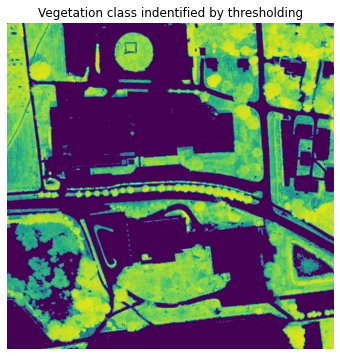

In [ ]:
# Thresholding the NDVI image
threshold = 0.3
thesrhold_ndvi = ndvi_image_python.copy()
thesrhold_ndvi[thesrhold_ndvi < threshold] = 0

# Displaying the NDVI image with only vegetation class
plt.subplots(1,1,figsize=(7,6))
plt.imshow(thesrhold_ndvi)
plt.title("Vegetation class indentified by thresholding")
plt.axis('off')
plt.show()

<center>Figure- 30: Vegetation class indentified by thresholding</center>

### Detecting edges of the vegetation class
For detecting the edges, I have used 4 filters:
1. Prewitt
2. Sobel
3. Canny (using with sigma value 3)
4. Laplace

Since the edges detected by the filters were quite thin, for the better visualisation purpose, I have used the dilation  with square(2) and square(3) on all the edges for making them look thicker.

In [ ]:
# Function for detecting edges from the given image
def edge_operator(image, operator):
    shape = np.shape(image)
    if len(shape) == 3:
        image = image.mean(axis=2)
    elif len(shape) > 3:
        raise ValueError('Must be at 2D image')

    filtered = None
    if operator == 1:
        filtered = filters.sobel(image)
    elif operator == 2:
        filtered = filters.prewitt(image)
    elif operator == 3:
        filtered = feature.canny(image, sigma=3)
    elif operator == 4:
        filtered = filters.laplace(image)
    else:
        return "you have given wrong operator"

    # Improving the thickness of the edges
    if operator != 3:
        for iteration in range(2):
            filtered = dilation(filtered, square(2))
    else:
        filtered = dilation(filtered, square(3))
    return filtered

# Function for displaying the results edges/outline of the vegetation
def show_edge_detection():
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 9))
    fig.suptitle("Vegetation outlined by the Edge detecting filters", fontsize = 13)

    ax[0,0].imshow(sobel_edge, cmap='gray')
    ax[0,0].set_title('Sobel', fontsize = 12)

    ax[0, 1].imshow(prewitt_edge, cmap='gray')
    ax[0, 1].set_title(r'Prewitt', fontsize = 12)

    ax[1, 0].imshow(canny_edge, cmap='gray')
    ax[1, 0].set_title(r'Canny', fontsize = 12)

    ax[1, 1].imshow(laplace_edge, cmap='gray')
    ax[1, 1].set_title(r'Laplace', fontsize = 12)

    for row in ax:
        for col in row:
            col.axis('off')

    fig.tight_layout()
    plt.show()

In [ ]:
# Calling the edge detecting filters on the vegetation class
sobel_edge = edge_operator(thesrhold_ndvi, 1)
prewitt_edge = edge_operator(thesrhold_ndvi, 2)
canny_edge = edge_operator(thesrhold_ndvi, 3)
laplace_edge = edge_operator(thesrhold_ndvi, 4)

# Displaying the results of edge detection filter on  vegetaion class
show_edge_detection()

<center>Figure- 31: Vegetation outlined by the Edge detecting filters</center>

### Comment on the edge detecting filters on vegetation class.
- From the Figure-31, we can see that
  - The results of the Sobel and Prewitt on the vegetation class were almost similar.
  - The Canny (with sigma value 3) had much more defiend edges and less noises compared to all the edge detecting filters [**Best**]
  - The Laplace had the **worst** result among the filters.
  
Hence, for the overlaying purpose only the Sobel, Prewitt and Canny have been used.


### Outlining the vegetation using the edge detected images

Since the edges of the vegetation class has been identified in the white color(255) and the rest of the image is black(0), we can easily use the masking logic here. Hence, from both the images (edge detected and NDVI image) the maximum value for each pixel is taken for generating the new vegetation outlined image. Since the edges have the highest value(255) among the other pixels, the edges are preserved on the new generated image.

In [ ]:
# Generating the overlay image/vegetation outlined image using 2 images: (1)Edge detected image and (2)NDVI image
def generate_overlay(edge_detected_image, NDVI_image):
    shape = np.shape(edge_detected_image)
    overlay_image = np.zeros([shape[0], shape[1]])

    #For each pixel taking the max value
    for i in range(shape[0]):
        for j in range(shape[1]):
            max_val = max(float(edge_detected_image[i,j]), float(NDVI_image[i,j]))
            overlay_image[i, j] = max_val

    return overlay_image

# Displaying the vegetation outlined image
def display_overlay_images():
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (13, 5.5))
    fig.suptitle("Outlined vegetation by overlay", fontsize = 14)

    ax[0].imshow(sobel_overlay)
    ax[0].set_title('Sobel overlay', fontsize = 12)

    ax[1].imshow(prewitt_overlay)
    ax[1].set_title(r'Prewitt overlay', fontsize = 12)

    ax[2].imshow(canny_overlay)
    ax[2].set_title(r'Canny overlay', fontsize = 12)

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

In [ ]:
# Generating overlays for each edge detected image
sobel_overlay = generate_overlay(sobel_edge, ndvi_image_python)
prewitt_overlay = generate_overlay(prewitt_edge, ndvi_image_python)
canny_overlay = generate_overlay(canny_edge, ndvi_image_python)

# Displaying the overlayed/vegetation outlined images
display_overlay_images()

<center>Figure- 32: Outlined vegetation by overlay</center>

### Comment on the vegetation outlining:
From the Figure- 32, we can see that-
- The Sobel and Prewitt version of the outlined images have the same results because their edge detecting styles were similar.
- The Canny has the **best** outlined image and it also **matched with the sample image** of the question.